In [51]:
import random
import time
import os
import glob 
import networkx as nx
import numpy as np
from copy import deepcopy
from tabulate import tabulate
from matplotlib import pyplot as plt

RESULTS_PATH = "resultsGA"

if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)

# Omogućava prikaz grafikona unutar Notebook-a
%matplotlib inline

In [52]:
def maxNumOfColours(graph):
    maxDegree = 0
    for i in graph:
        degree = len(list(graph.neighbors(i)))
        if degree > maxDegree:
            maxDegree = degree
    return maxDegree

def readGraph(filePath):
    graph = nx.Graph()
    with open(filePath) as f:
        lines = f.readlines()

        #.txt fajl, da ne pukne osiguravamo se zbog pocetka sa p
        pLine = [l for l in lines if l.startswith('p')]
        if pLine:
            numNodes = int(pLine[0].split()[2])
        else:
            numNodes = int(lines[0].split()[2])
        

        #numNodes = int(lines[0].split()[2])
        # Normalizacija grana: sorted osigurava da je (1,2) isto što i (2,1)
        rawEdges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        edges = [tuple(sorted(edge)) for edge in rawEdges]
        graph.add_nodes_from(range(1, numNodes + 1))
        graph.add_edges_from(edges)
    return graph

def getFitness(chromosome, edges, maxNode):
    conflicts = 0
    nodeMap = {i: [] for i in range(1, maxNode + 1)}
    for i, color in enumerate(chromosome):
        u, v = edges[i]
        nodeMap[u].append(color)
        nodeMap[v].append(color)
    for node in nodeMap:
        colors = nodeMap[node]
        if len(colors) > 1:
            conflicts += (len(colors) - len(set(colors)))
    return conflicts

In [53]:
def selectionTournament(population, fitnesses, k=3):
    participants = random.sample(list(zip(population, fitnesses)), k)
    return min(participants, key=lambda x: x[1])[0]

def selectionRoulette(population, fitnesses):
    # Što manji fitnes, to veća šansa (proporcionalno 1/f)
    invertedFitness = [1.0 / (f + 1e-6) for f in fitnesses]
    total = sum(invertedFitness)
    pick = random.uniform(0, total)
    current = 0
    for i, f in enumerate(invertedFitness):
        current += f
        if current > pick:
            return population[i]
    return population[0]

def selectionRank(population, fitnesses):
    popSize = len(population)
    sortedIndices = np.argsort(fitnesses)[::-1] 
    ranks = np.empty(popSize)
    for rank, idx in enumerate(range(popSize)):
        ranks[sortedIndices[idx]] = rank + 1
    totalRank = sum(ranks)
    pick = random.uniform(0, totalRank)
    current = 0
    for i in range(popSize):
        current += ranks[i]
        if current > pick: return population[i]
    return population[0]

In [54]:
def crossoverUniform(p1, p2):
    return [p1[i] if random.random() < 0.5 else p2[i] for i in range(len(p1))]

def crossoverSinglePoint(p1, p2):
    point = random.randint(1, len(p1) - 1)
    return p1[:point] + p2[point:]

def crossoverTwoPoint(p1, p2):
    size = len(p1)
    if size < 3: return crossoverSinglePoint(p1, p2)
    pt1 = random.randint(1, size - 2)
    pt2 = random.randint(pt1 + 1, size - 1)
    return p1[:pt1] + p2[pt1:pt2] + p1[pt2:]

In [55]:
def mutationSmart(chromosome, edges, maxNode, delta):
    idx = random.randrange(len(chromosome))
    u, v = edges[idx]
    forbidden = set()
    for i, (n1, n2) in enumerate(edges):
        if i != idx and (n1 in (u, v) or n2 in (u, v)):
            forbidden.add(chromosome[i])
    available = list(set(range(1, delta + 2)) - forbidden)
    if available:
        chromosome[idx] = random.choice(available)
    else:
        chromosome[idx] = random.randint(1, delta + 1)
    return chromosome

def mutationRandom(chromosome, edges, maxNode, delta):
    idx = random.randrange(len(chromosome))
    chromosome[idx] = random.randint(1, delta + 1)
    return chromosome

def mutationSwap(chromosome, edges, maxNode, delta):
    idx1, idx2 = random.sample(range(len(chromosome)), 2)
    chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
    return chromosome

In [56]:
def runGaModular(graph, maxIters, popSize, selFunc, crossFunc, mutFunc):
    edges = list(graph.edges())
    if not edges: return [], 0, []
    maxNode, delta, numEdges = max(graph.nodes()), maxNumOfColours(graph), len(edges)
    population = [[random.randint(1, delta + 1) for _ in range(numEdges)] for _ in range(popSize)]
    
    history = [] # Za grafikon konvergencije
    
    for gen in range(maxIters):
        fitnesses = [getFitness(c, edges, maxNode) for c in population]
        bestFit = min(fitnesses)
        history.append(bestFit)
        
        if bestFit == 0:
            history.extend([0] * (maxIters - len(history)))
            break
            
        popWithFit = sorted(zip(population, fitnesses), key=lambda x: x[1])
        newPop = [popWithFit[0][0], popWithFit[1][0]] # Elitizam
        
        while len(newPop) < popSize:
            p1, p2 = selFunc(population, fitnesses), selFunc(population, fitnesses)
            child = crossFunc(p1, p2)
            if random.random() < 0.3:
                child = mutFunc(child, edges, maxNode, delta)
            newPop.append(child)
        population = newPop
        
    finalFits = [getFitness(c, edges, maxNode) for c in population]
    bestIdx = np.argmin(finalFits)
    return population[bestIdx], finalFits[bestIdx], history

In [57]:
def processAndVisualize(filePath):
    graph = readGraph(filePath)
    fileName = os.path.basename(filePath)
    delta = maxNumOfColours(graph)
    
    selections = [selectionTournament, selectionRoulette, selectionRank]
    crossovers = [crossoverSinglePoint, crossoverUniform, crossoverTwoPoint]
    mutations = [mutationRandom, mutationSmart, mutationSwap]
    
    allResults = []

    print(f"\n>>> ANALYZING GRAPH: {fileName}")
    for sel in selections:
        for cross in crossovers:
            for mut in mutations:
                sName = sel.__name__.replace('selection', '')
                cName = cross.__name__.replace('crossover', '')
                mName = mut.__name__.replace('mutation', '')
                
                t0 = time.perf_counter()
                sol, fit, hist = runGaModular(graph, 250, 40, sel, cross, mut)
                dt = time.perf_counter() - t0
                
                allResults.append({
                    'selection': sName,
                    'crossover': cName,
                    'mutation': mName,
                    'fit': fit,
                    'time': dt,
                    'hist': hist,
                    'sol': sol
                })

    allResults.sort(key=lambda x: (x['fit'], x['time']))
    
    # odvojene kolone
    fullTableData = []
    for i, r in enumerate(allResults):
        fullTableData.append([
            i, 
            r['selection'], 
            r['crossover'], 
            r['mutation'], 
            r['fit'], 
            delta + 1, 
            f"{r['time']:.6f}"
        ])

    headers = ["", "selection", "crossover", "mutation", "num of conf", "colours", "time"]

    # 1. konzola: top 3
    print(f"Top 3 Combinations for {fileName}:")
    print(tabulate(fullTableData[:3], headers=headers, tablefmt="fancy_grid"))

    # 2. fajl: svih 27
    txtPath = os.path.join(RESULTS_PATH, fileName) 
    with open(txtPath, 'w', encoding='utf-8') as f:
        f.write(f"Graph can be coloured with {delta} or {delta+1} colours. Class 1 or class 2 respectively.\n")
        f.write(tabulate(fullTableData, headers=headers, tablefmt="fancy_grid"))
        if allResults[0]['fit'] == 0:
            f.write(f"\nGraph is class 1, meaning chromatic index is equal to the graph's degree.")
        else:
            f.write(f"\nNo conflict-free colouring is found, therefore graph is classified as class 2.")

    # 3. VIZUELIZACIJA
    plt.figure(figsize=(16, 7))
    
    # podplot 1: Obojeni graf
    plt.subplot(1, 2, 1)
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph, pos, edge_color=allResults[0]['sol'], width=2, with_labels=True, 
            node_color='lightblue', edge_cmap=plt.cm.rainbow)
    plt.title(f"Winner (Rank 0):\n{allResults[0]['selection']} + {allResults[0]['crossover']} + {allResults[0]['mutation']}")

    # podplot 2: Konvergencija
    plt.subplot(1, 2, 2)
    for i in range(min(3, len(allResults))):
        res = allResults[i]
        # ISPIS SVA TRI OPERATORA U LEGENDI:
        label_name = f"Rank {i}: {res['selection']} + {res['crossover']} + {res['mutation']}"
        plt.plot(res['hist'], label=label_name, linewidth=2.5)
    
    # osa
    plt.xlabel("Generations (Algorithm Progress)", fontsize=11)
    plt.ylabel("Number of Conflicts (Fitness)", fontsize=11)
    plt.title(f"Convergence Race: Top 3 Algorithms for {fileName}", fontsize=13)
    
    # namestanje legende
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True, linestyle=':', alpha=0.8)
    
    plt.tight_layout()
    plt.show()

    print(f"Full table (27 combinations) saved to: {txtPath}")
    
    


########################################
# ENTERING FOLDER: smallTests
########################################

>>> ANALYZING GRAPH: graph10.txt
Top 3 Combinations for graph10.txt:
╒════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│    │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│  0 │ Roulette    │ SinglePoint │ Random     │             0 │         4 │ 0.002621 │
├────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│  1 │ Roulette    │ Uniform     │ Smart      │             0 │         4 │ 0.002648 │
├────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│  2 │ Roulette    │ TwoPoint    │ Smart      │             0 │         4 │ 0.003096 │
╘════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════════╧══════════╛


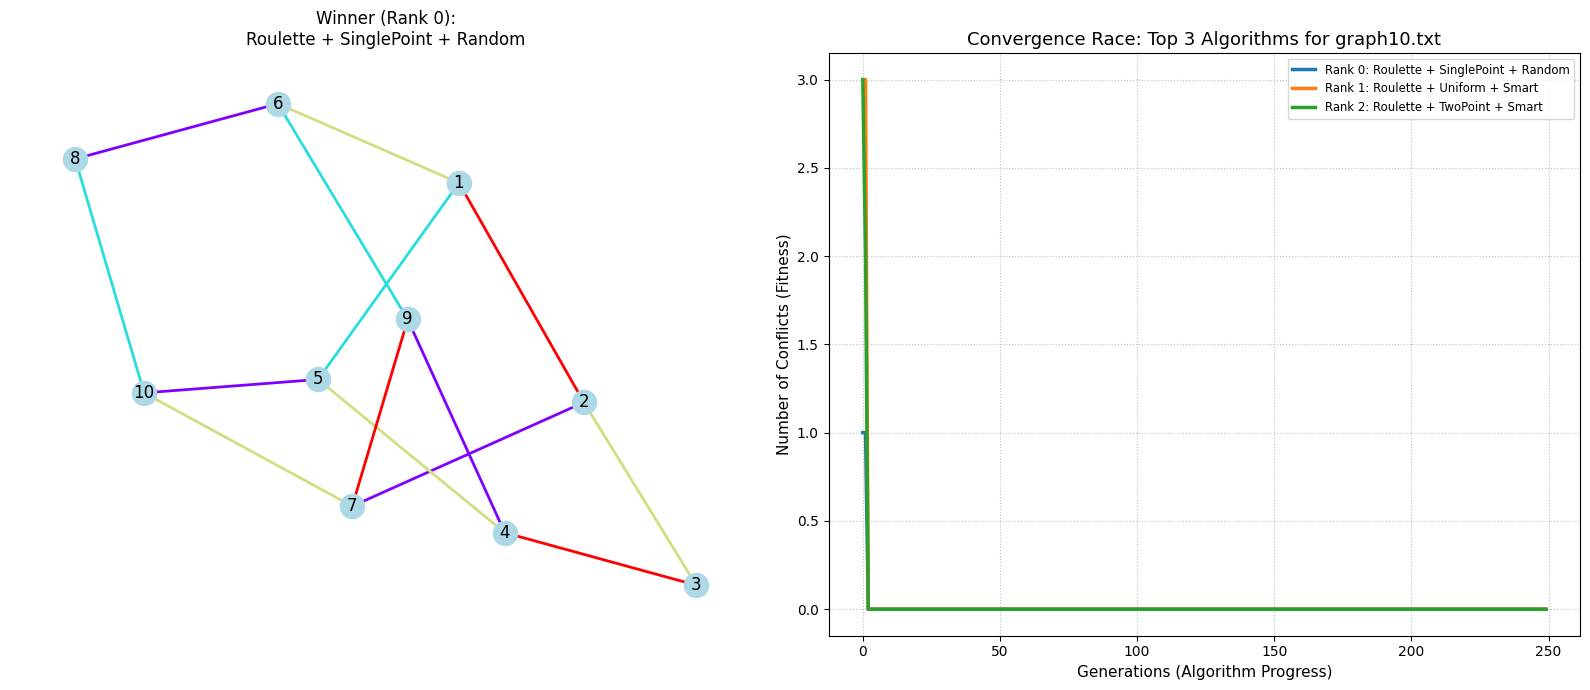

Full table (27 combinations) saved to: resultsGA/graph10.txt

>>> ANALYZING GRAPH: graph5.txt
Top 3 Combinations for graph5.txt:
╒════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│    │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│  0 │ Roulette    │ SinglePoint │ Smart      │             0 │         4 │ 0.00037  │
├────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│  1 │ Roulette    │ SinglePoint │ Swap       │             0 │         4 │ 0.000371 │
├────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│  2 │ Roulette    │ Uniform     │ Smart      │             0 │         4 │ 0.000395 │
╘════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════════╧══════════╛


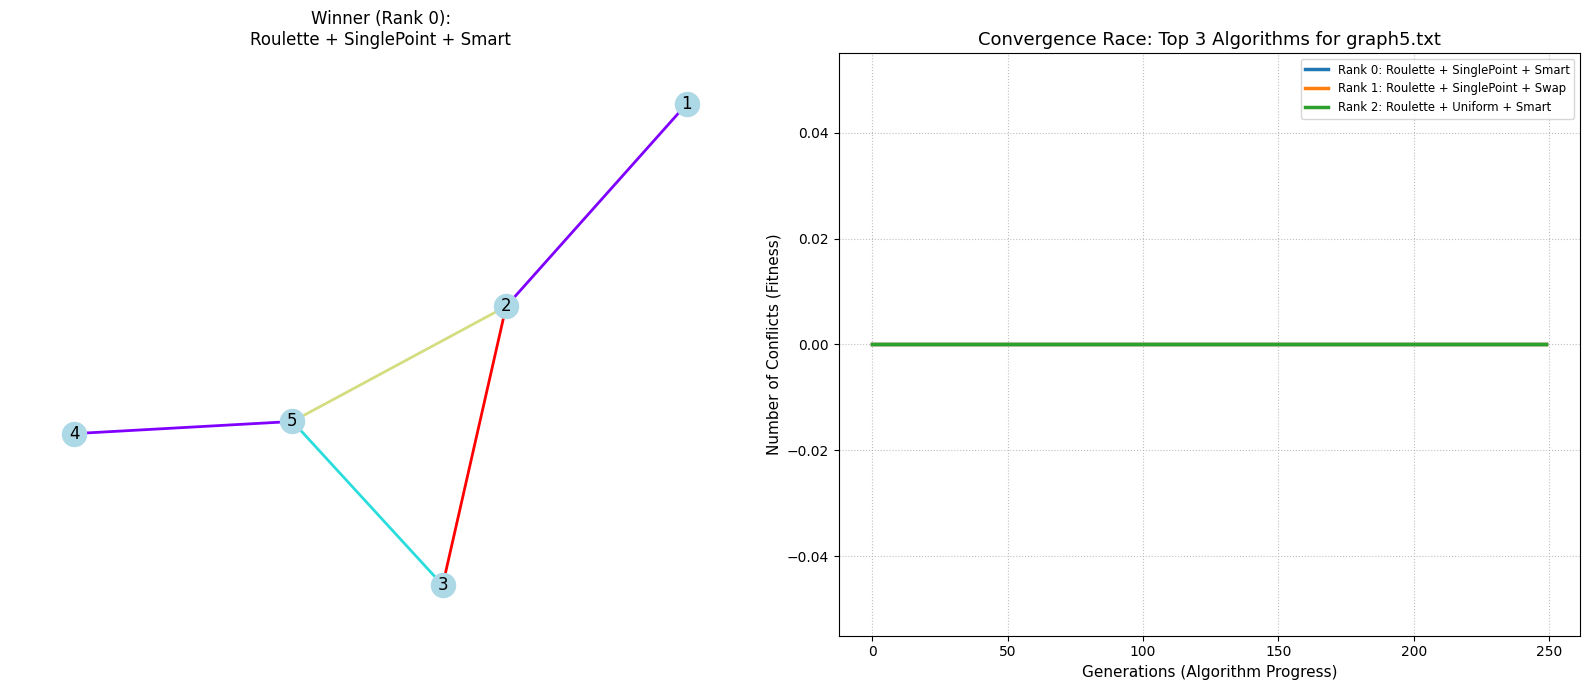

Full table (27 combinations) saved to: resultsGA/graph5.txt

>>> ANALYZING GRAPH: graph6.txt
Top 3 Combinations for graph6.txt:
╒════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│    │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│  0 │ Rank        │ TwoPoint    │ Random     │             0 │         4 │ 0.000655 │
├────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│  1 │ Tournament  │ TwoPoint    │ Swap       │             0 │         4 │ 0.000735 │
├────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│  2 │ Roulette    │ TwoPoint    │ Swap       │             0 │         4 │ 0.000799 │
╘════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════════╧══════════╛


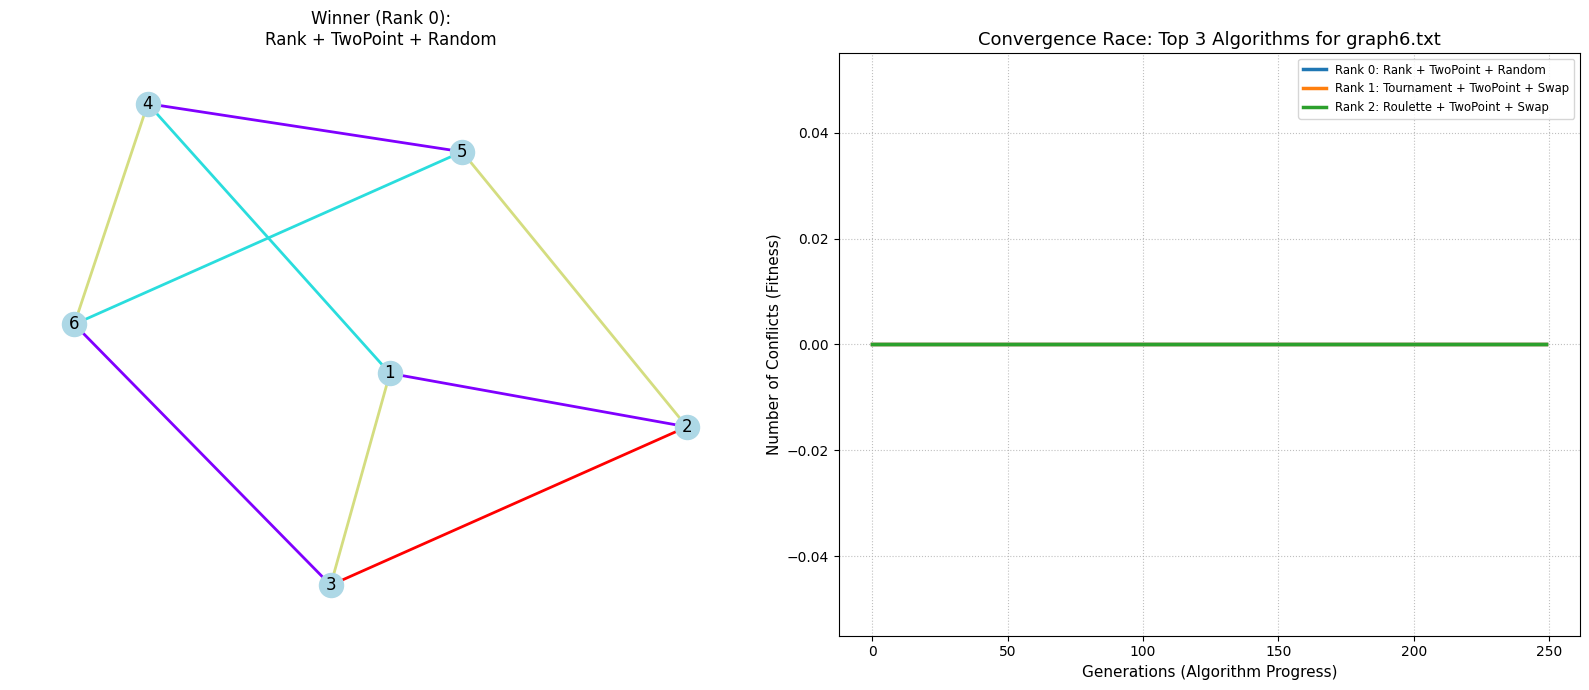

Full table (27 combinations) saved to: resultsGA/graph6.txt

########################################
# ENTERING FOLDER: bigTests
########################################

>>> ANALYZING GRAPH: big22.txt
Top 3 Combinations for big22.txt:
╒════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│    │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│  0 │ Tournament  │ TwoPoint    │ Smart      │             0 │        18 │ 0.159474 │
├────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│  1 │ Tournament  │ SinglePoint │ Smart      │             0 │        18 │ 0.194473 │
├────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│  2 │ Tournament  │ Uniform     │ Smart      │             0 │        18 │ 0.20999  │
╘════╧═════════════╧═════════════╧════════════╧═══════════════╧════

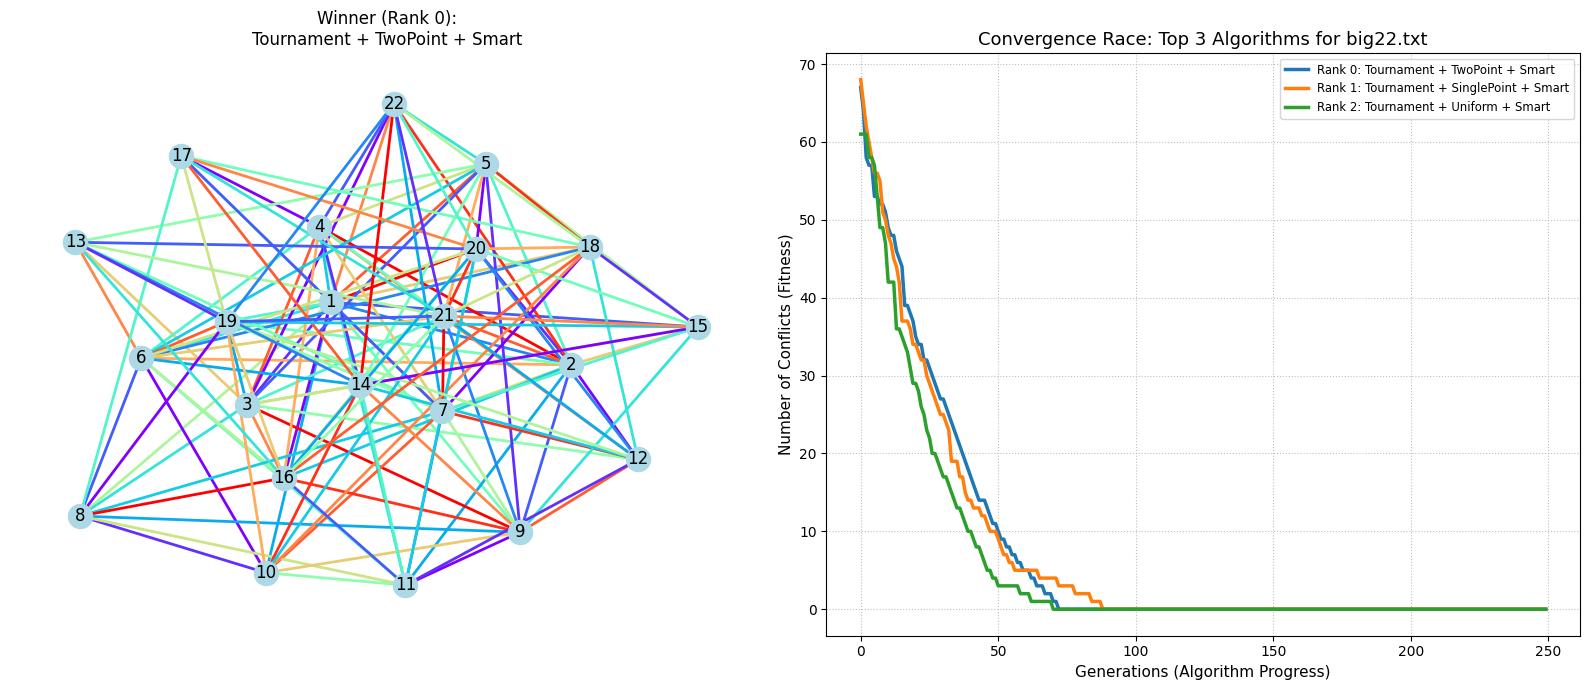

Full table (27 combinations) saved to: resultsGA/big22.txt

>>> ANALYZING GRAPH: big30.txt
Top 3 Combinations for big30.txt:
╒════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│    │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│  0 │ Tournament  │ SinglePoint │ Smart      │             0 │        24 │ 1.1013  │
├────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│  1 │ Tournament  │ Uniform     │ Smart      │             1 │        24 │ 1.19389 │
├────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│  2 │ Rank        │ Uniform     │ Smart      │             1 │        24 │ 1.77107 │
╘════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════════╧═════════╛


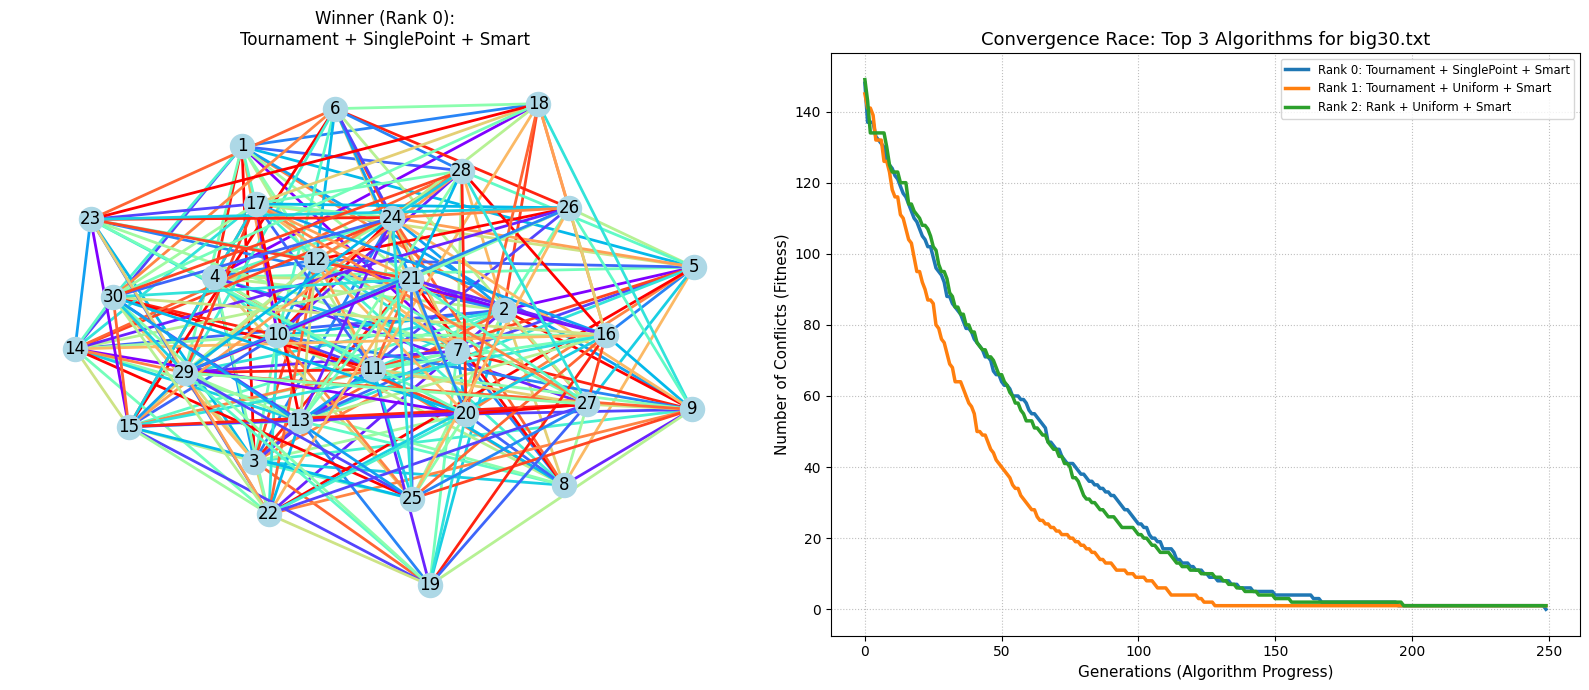

Full table (27 combinations) saved to: resultsGA/big30.txt

>>> ANALYZING GRAPH: big47.6.txt
Top 3 Combinations for big47.6.txt:
╒════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤══════════╕
│    │ selection   │ crossover   │ mutation   │   num of conf │   colours │     time │
╞════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪══════════╡
│  0 │ Tournament  │ Uniform     │ Smart      │             0 │        24 │ 0.354665 │
├────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│  1 │ Tournament  │ SinglePoint │ Smart      │             0 │        24 │ 0.363525 │
├────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼──────────┤
│  2 │ Tournament  │ TwoPoint    │ Smart      │             0 │        24 │ 0.440723 │
╘════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════════╧══════════╛


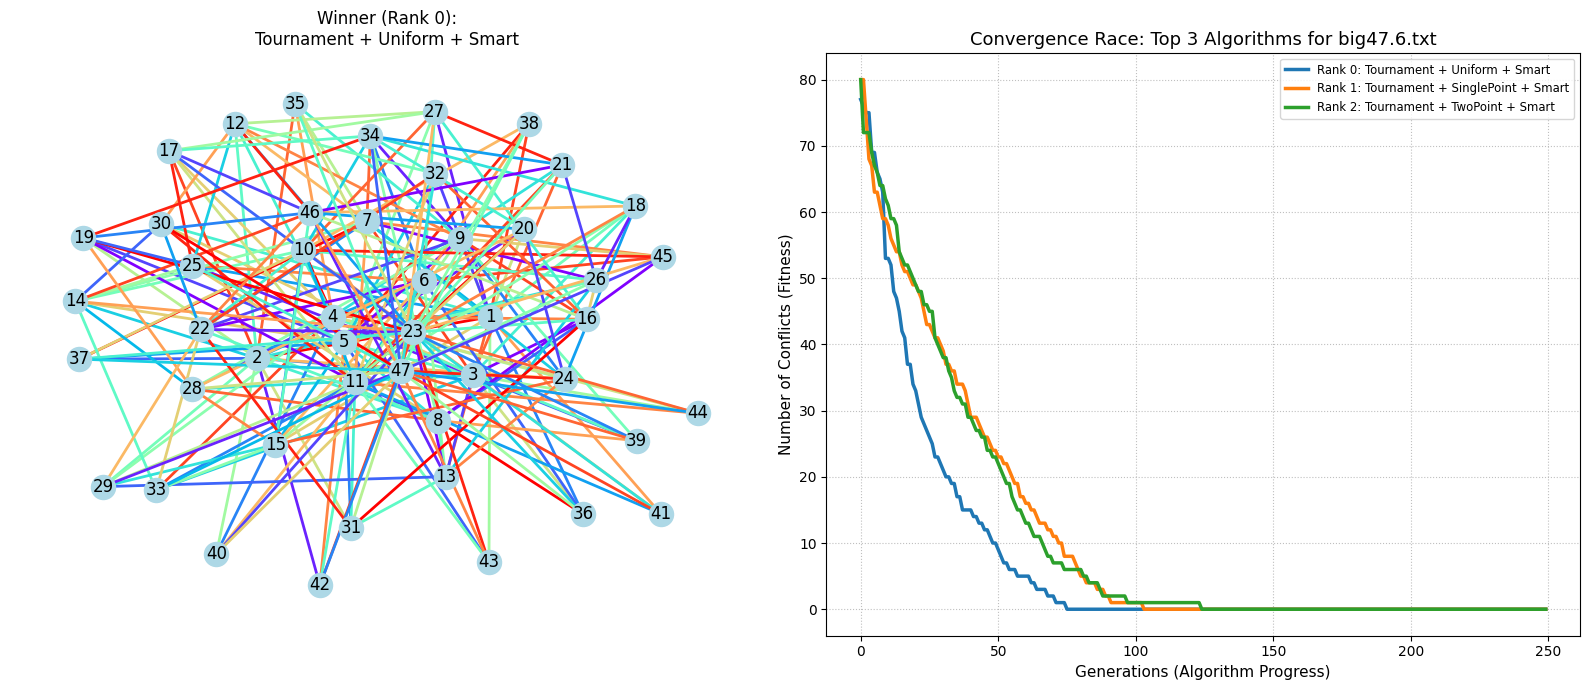

Full table (27 combinations) saved to: resultsGA/big47.6.txt

>>> ANALYZING GRAPH: big95.txt
Top 3 Combinations for big95.txt:
╒════╤═════════════╤═════════════╤════════════╤═══════════════╤═══════════╤═════════╕
│    │ selection   │ crossover   │ mutation   │   num of conf │   colours │    time │
╞════╪═════════════╪═════════════╪════════════╪═══════════════╪═══════════╪═════════╡
│  0 │ Tournament  │ Uniform     │ Smart      │             0 │        48 │ 2.85496 │
├────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│  1 │ Rank        │ Uniform     │ Smart      │             4 │        48 │ 4.04309 │
├────┼─────────────┼─────────────┼────────────┼───────────────┼───────────┼─────────┤
│  2 │ Tournament  │ SinglePoint │ Smart      │            12 │        48 │ 2.86976 │
╘════╧═════════════╧═════════════╧════════════╧═══════════════╧═══════════╧═════════╛


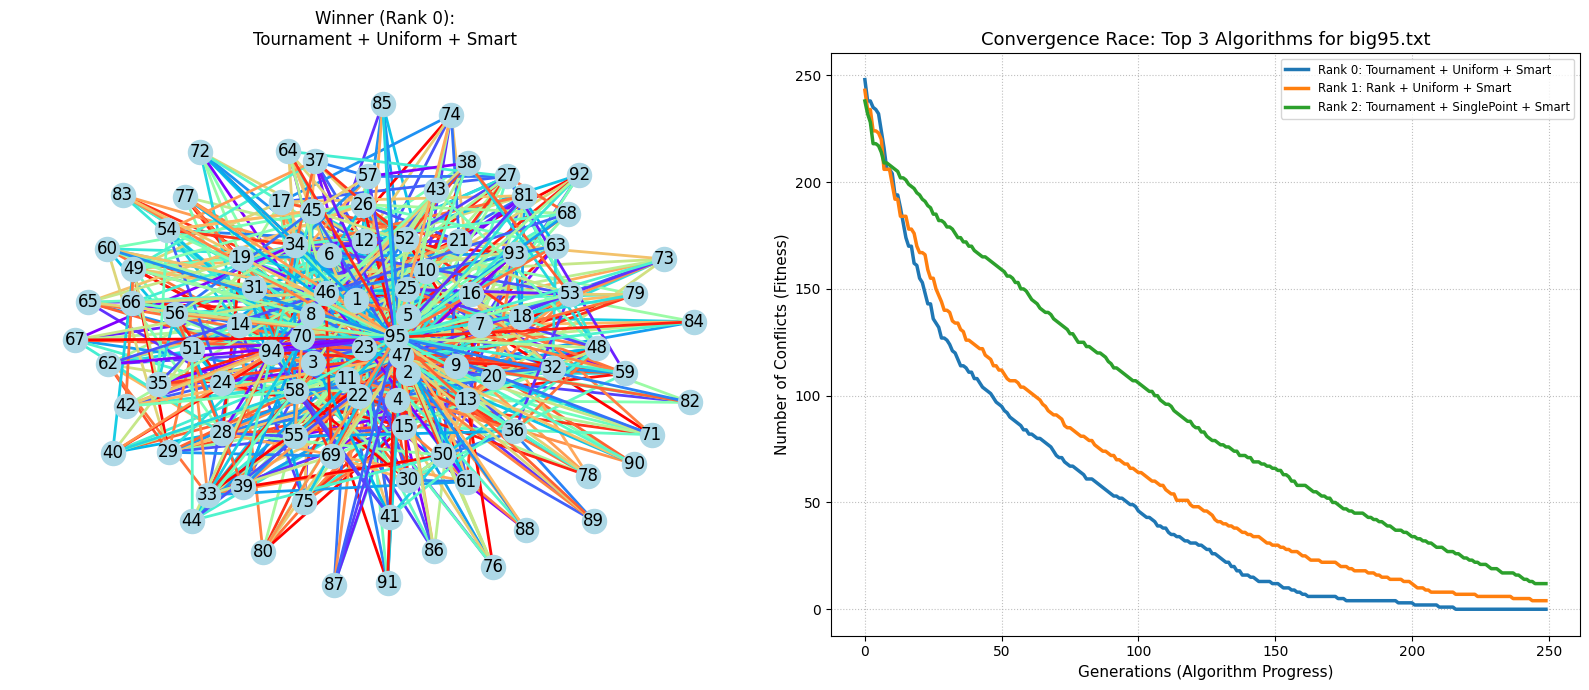

Full table (27 combinations) saved to: resultsGA/big95.txt


In [58]:
#Novo ucitavanje fajla

targetFolders = ['smallTests','bigTests']

for folder in targetFolders:
    #kreiramo putanju za pretragu
    searchPath = os.path.join('tests',folder,"*.txt")
    allFiles = sorted(glob.glob(searchPath))

    if not allFiles:
        print(f"No files found in: tests/{folder}")
        continue

    print(f"\n{'#'*40}\n# ENTERING FOLDER: {folder}\n{'#'*40}")

    for f in allFiles:
        #fileName = os.path.basename(f)
        processAndVisualize(f)